# Learning From Demonstration (LfD) with Dynamical Systems (DS) Tutorial 
This is a simple Learning from Demonstration example based on the methods described in the papers listed below. For a more in-depth explanation of the theory and comprehension, look at the tutorial slides and examples provided at https://epfl-lasa.github.io/TutorialICRA2019.io/. 

## References
* [1] Figueroa, N. and Billard, A. (2018) A Physically-Consistent Bayesian Non-Parametric Mixture Model for Dynamical System Learning. In Proceedings of the 2nd Conference on Robot Learning (CoRL).
* [2] Khansari Zadeh, S. M. and Billard, A. (2011) Learning Stable Non-Linear Dynamical Systems with Gaussian Mixture Models. IEEE Transaction on Robotics, vol. 27, num 5, p. 943-957.



In [1]:
from casadi import *
import numpy
import scipy
import matplotlib.pyplot as plt
import itertools

from scipy import linalg
import scipy
from sklearn import mixture

from utils import *
from matplotlib.figure import Figure



In [2]:
# Declare State Variables
nX = 2
nXdot = 2

ws_lims = np.array([[0., 1.], [0., 1.]])
ws_center = np.array([0.5, 0.5])

Trajectory 0 (67,) (67,)
Trajectory 1 (47,) (47,)
Trajectory 2 (48,) (48,)
Trajectory 3 (44,) (44,)


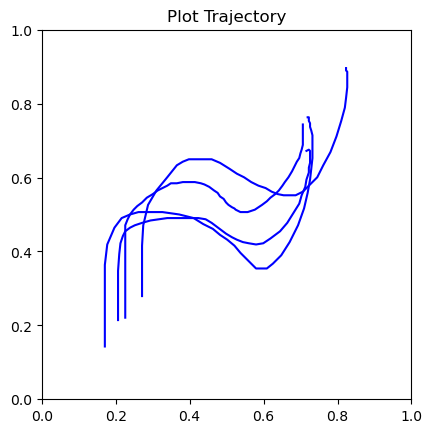

In [3]:
# Load Trajectories
# Load the list of arrays back from the .npy file
trajectories = np.load('demo_trajectories.npy', allow_pickle=True)

# Create a Matplotlib figure and axis
fig, ax = plt.subplots()


# Verify the loaded data
for i in range(len(trajectories)):
    print(f"Trajectory {i}", trajectories[i][0].shape, trajectories[i][1].shape)
    ax.plot(trajectories[i][0], trajectories[i][1], 'b-')

ax.set_aspect('equal', 'box')
ax.set_title("Plot Trajectory")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.show()


In [4]:

# Calculate Attractor
ends = []
starts = []
for i in range(len(trajectories)):
    ends.append(np.array([trajectories[i][0][-1], trajectories[i][1][-1]]))
    starts.append(np.array([trajectories[i][0][0], trajectories[i][1][0]]))
ends = np.array(ends)
starts = np.array(starts)
ends_mean, ends_std = [np.mean(ends,  axis=0), np.std(ends, axis=0)]
print(ends_mean, ends_std)
# Define the threshold value
threshold = .1

# Create a boolean mask where elements are less than the threshold
are_all_less = (ends_std < threshold).all()

# If endpoints of trajectories are clustered, set mean as attractor. Otherwise, center of workspace
if are_all_less: 
    attractor = ends_mean # Mean of Trajectory Endpoints
else: 
    attractor = ws_center #Center of workspace

starts_mean, starts_std = [np.mean(starts,  axis=0), np.std(starts, axis=0)]




[0.74107143 0.76866883] [0.04757214 0.080986  ]


4
(67, 2)
(47, 2)
(48, 2)
(44, 2)


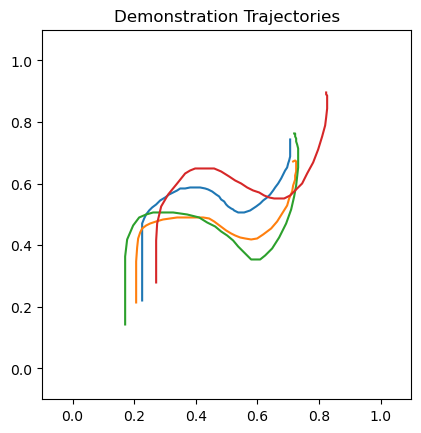

(206, 2) (206, 2)


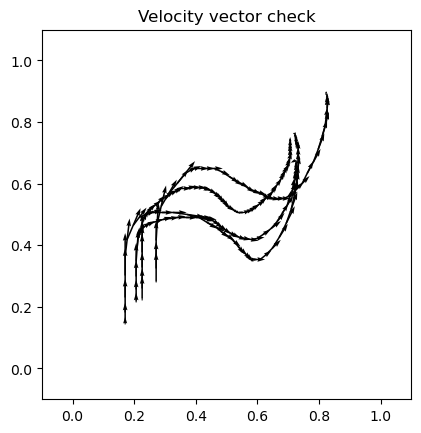

In [16]:
# Change Data to Timed Trajectories
dt = 0.01 # Set as dt
Xref = []
Xdotref = [] 
print(len(trajectories))
fig, ax = plt.subplots()
for i in range(len(trajectories)):
    traj = np.array([trajectories[i][0], trajectories[i][1]]).T
    ax.plot(traj[:,0], traj[:,1])
    print(traj.shape)
    for j in range(len(traj)-1):
        vel = (traj[j+1]-traj[j])/dt
        Xref.append(traj[j])
        Xdotref.append(vel)
    Xref.append(traj[-1])
    Xdotref.append(np.zeros(2))

ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.1,1.1])
ax.set_aspect('equal', 'box')
ax.set_title('Demonstration Trajectories')
plt.show()

Xref = np.array(Xref)
Xdotref = np.array(Xdotref)

print(Xref.shape, Xdotref.shape)

fig, ax = plt.subplots()
ax.quiver(Xref[:,0], Xref[:,1], Xdotref[:,0], Xdotref[:,1])

ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.1,1.1])
ax.set_aspect('equal', 'box')
ax.set_title('Velocity vector check')
plt.show()


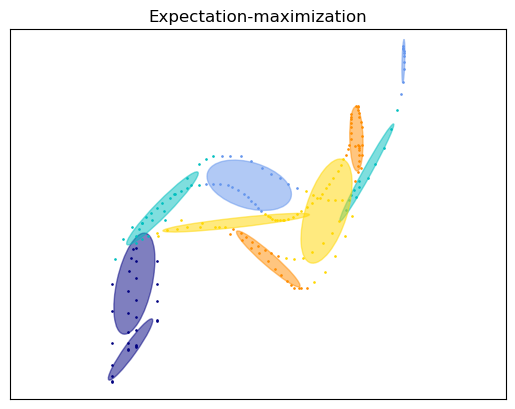

In [6]:
# Learn GMM
num_components = 10 # Number of GMM components
gmm = mixture.GaussianMixture(n_components=num_components, covariance_type="full", max_iter=100).fit(Xref)
plot_results(Xref, gmm.predict(Xref), gmm.means_, gmm.covariances_, 0, "Expectation-maximization"
)

In [7]:
# Define GMM Variables
numSamples = len(Xref)
centers = gmm.means_
gammaX = gmm.predict_proba(Xref) # Weights of Each GMM component for each trajectory sample point (wrt position)

# Initialize Optimization Variables for learning LPV-DS system 
A = []
b = []
A0 = []
b0 = []
for k in range(num_components):
    A0.append(np.eye(nX))#*0) #Initialize A variable as Identity
    b0.append(np.zeros(2)) # Initialize b variable as zeros
    A.append(SX.sym("A"+str(k),nX,nX)) # Create A matrix (N x N) for kth component
    b.append(SX.sym("b"+str(k),nX,1)) # Create B matrix (N x 1) for kth component
A0 = np.array(A0)
b0 = np.array(b0)

P = np.identity(nX) # for simplicity, set P to Identity. (will also be a optimization variable for LPV-system)
eps = 0.001 # Lyapunov Constraint Threshold


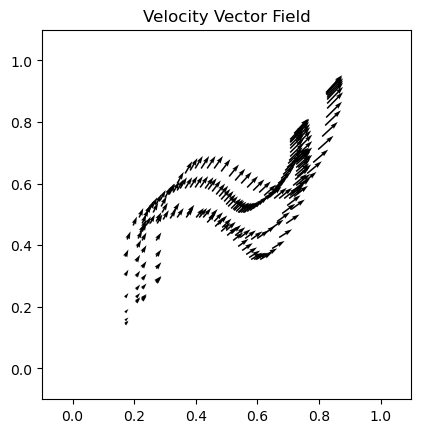

In [8]:
# Verify initial Values are for A,b are zero velocity
Xdot= np.zeros(Xdotref.shape)
for i in range(len(Xref)):
    # Calculate velocity
    vel = np.zeros(nXdot)
    gamma = gammaX[i]
    for k in range(gmm.n_components):
        vel = vel + (gamma[k]*(A0[k]@Xref[i] + b0[k])) 
    Xdot[i] = vel

fig, ax = plt.subplots()
ax.quiver(Xref[:,0], Xref[:,1], Xdot[:,0], Xdot[:,1])

ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.1,1.1])
ax.set_aspect('equal')
ax.set_title('Velocity Vector Field')
plt.show()

In [9]:
### Define the NLP

# Define objective
cost = 0
for i in range(numSamples):
    # get gamma
    gamma = gammaX[i]

    # Calculate velocity
    vel = np.zeros(nXdot)
    for k in range(num_components):
        vel = vel + (gamma[k]*(A[k]@Xref[i] + b[k])) 
    
    # Calculate error
    err = casadi.sum((vel - Xdotref[i])**2) #L2-norm eqn so no blowing up near 0
    cost = cost + err

In [10]:
# Lyapunov Stability Constraints

# Generate Constraint Equations (inequality and equality Constraints)
ineq_constraints = casadi.reshape(A[0].T + A[0], 4,1)
eq_constraints = casadi.reshape(b[0]+A[0]@attractor, 2,1)

for k in range(1,num_components):
    ineq_constraints = casadi.vertcat(ineq_constraints, casadi.reshape(A[k].T + A[k], 4,1)) # for simplicity, no P matrix in constraint
    # ineq_constraints = casadi.vertcat(ineq_constraints, casadi.reshape(A[k].T@P + P@A[k]+eps*np.identity(nX), 4,1))
    eq_constraints = casadi.vertcat(eq_constraints, casadi.reshape(b[k]+A[k]@attractor,2,1))

# Concatenate all constraints into single list
constraints = casadi.vertcat(ineq_constraints, eq_constraints)

# Generate Upper and Lower bounds for Inequality constraint (A.T + A <= -eps)
ineq_ulim = np.ones(num_components*nX**2) * -eps
ineq_llim = np.ones(num_components*nX**2)*-np.inf

# Generate Equality bounds for Equality Constraints (b_k = -A_k*Attractor, aka b_k+A_k*attractor = 0)
eq_vals = np.zeros(num_components*nX)

# Concatenate all constraint upper and lower bounds into single list
constraints_ulim = casadi.vertcat(ineq_ulim, eq_vals)
constraints_llim = casadi.vertcat(ineq_llim, eq_vals)


In [11]:
# Flatten A and b optimization variables into single list
optvar = casadi.reshape(A[0], 4,1)
for k in range(1,num_components):
    optvar = casadi.vertcat(optvar, casadi.reshape(A[k], 4,1))

for k in range(num_components):
    optvar = casadi.vertcat(optvar, casadi.reshape(b[k], 2,1))

# Define optimization Problem
prob = { 'x': optvar,'f': cost,'g': constraints }

# Define initial Solution
optvar0 = np.hstack((A0.flatten(), b0.flatten()))

# Create and Solve NLP problem with IPOPT
solver = nlpsol('solver', 'ipopt', prob)
sol = solver(x0 = optvar0, lbg=constraints_llim, ubg = constraints_ulim)

# Print solution
print("-----")
print("objective at solution = ", sol["f"])
print("primal solution = ", sol["x"])
print("dual solution (x) = ", sol["lam_x"])
print("dual solution (g) = ", sol["lam_g"])


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:       60
Number of nonzeros in inequality constraint Jacobian.:       60
Number of nonzeros in Lagrangian Hessian.............:      930

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       20
Total number of inequality c

In [12]:
# Set Xsol to Solution of NLP Optimization
xsol = sol["x"].full()
# Separate Optimization solution into A, b variable solutions
Avar_len = num_components*nX**2
A_vals = xsol[:Avar_len]
b_vals = xsol[Avar_len:]

# Reshape A and b into appropriate dimensions
Atest = []
btest = []
for i in range(num_components):
    a = A_vals[(4*i):((4*i)+4)]
    b = b_vals[(2*i):((2*i)+2)]
    Atest.append(a.reshape((2,2), order="F"))
    btest.append(b.reshape((2,), order="F"))
A = np.array(Atest)
b = np.array(btest)



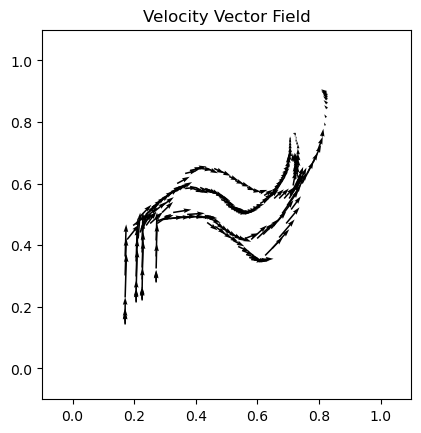

In [13]:
# Check results of DS learned with original input positions
X = Xref.copy()
Xdot= np.zeros(X.shape)
gammaPts = gmm.predict_proba(X)
for i in range(len(X)):
    # Calculate velocity
    vel = np.zeros(nXdot)
    gamma = gammaPts[i]
    for k in range(gmm.n_components):
        vel = vel + (gamma[k]*(A[k]@X[i] + b[k])) 
    Xdot[i] = vel

fig, ax = plt.subplots()
ax.quiver(X[:,0], X[:,1], Xdot[:,0], Xdot[:,1])

ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.1,1.1])
ax.set_aspect('equal')
ax.set_title('Velocity Vector Field')
plt.show()


(625, 2)


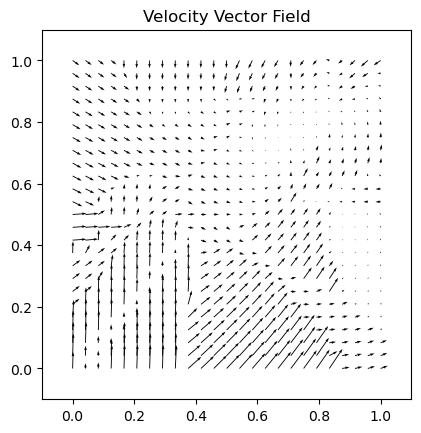

In [14]:
nx, ny = (25, 25)
x = np.linspace(0., 1., nx)
y = np.linspace(0., 1., ny)
xv, yv = np.meshgrid(x, y)

xvf = xv.flatten()
yvf = yv.flatten()
vxf = np.zeros(xvf.shape)
vyf = np.zeros(xvf.shape)
pts = np.vstack((xvf, yvf)).T

X = np.array(pts)
print(X.shape)
Xdot= np.zeros(X.shape)
gammaPts = gmm.predict_proba(pts)
vel = np.zeros((len(X), nXdot))
for i in range(len(X)):
    # Calculate velocity
    gamma = gammaPts[i]
    for k in range(gmm.n_components):
        vel[i] = vel[i] + (gamma[k]*(A[k]@pts[i] + b[k])) 
    Xdot[i] = vel[i]

fig, ax = plt.subplots()
ax.quiver(X[:,0], X[:,1], Xdot[:,0], Xdot[:,1])

ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.1,1.1])
ax.set_aspect('equal')
ax.set_title('Velocity Vector Field')
plt.show()
#

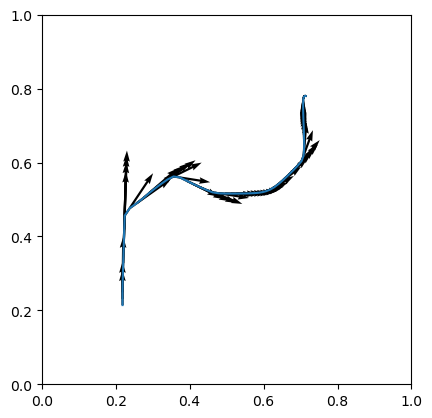

In [15]:
# Check Evolution of State over Time with Learned DS values
# Evolve x over time

xstart = starts_mean
x = xstart.copy()
X = [x]
vels = []
for step in range(100):
    vel = np.zeros(nXdot)
    gamma = gmm.predict_proba([x])[0]
    for k in range(num_components):
        vel = vel + (gamma[k]*(A[k]@x + b[k])) 
    x = x + vel*dt
    vels.append(vel)
    X.append(x)
vels.append(np.zeros(2))
X = np.array(X)
Y = np.array(vels)

fig, ax = plt.subplots()
ax.plot(X[:,0], X[:,1])
ax.quiver(X[:,0], X[:,1], Y[:,0], Y[:,1] )
ax.set_xlim(0., 1.)
ax.set_ylim(0.,1.)
ax.set_aspect('equal', 'box')
plt.show()